# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 60.0K/60.0K [05:06<00:00, 196File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

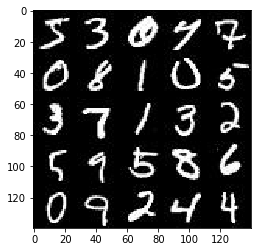

In [1]:
show_n_images = 25
import helper
data_dir = './data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

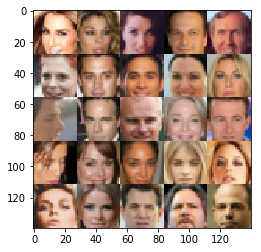

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
alpha=0.2           #--- for leaky relu in discriminator and generator
kernel_size = 5     #--- for deconv and conv layers discriminator and generator

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    #--- code adapted from DCGAN exercise
    with tf.variable_scope('discriminator', reuse=reuse):

        #--- input layer(images is 28x28x3 or 28x28x1)
        x1 = tf.layers.conv2d(images, 64, kernel_size, strides=2, padding='same')
        #--- don't apply batch normalization here... Mat says it causes weird artifacts
        x1 = tf.maximum(alpha * x1, x1)
        #--- 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, kernel_size, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        #--- 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, kernel_size, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        #--- 4x4x256  (7/2 strides = 4!)
        
        #---flatten
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    #--- code adapted from DCGAN exercise
    with tf.variable_scope('generator', reuse=not is_train):
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #--- 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, kernel_size, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #--- 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, kernel_size, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #--- 28x28x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size, strides=1, padding='same')
        #--- generates a 28x28xout_channel_dim image for inputs to the discriminator
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    #--- adapted from the GAN_MNIST and DCGAN exercise
    g_model = generator(input_z, out_channel_dim)
    
    d_real_model, d_real_logits = discriminator(input_real)
    d_fake_model, d_fake_logits = discriminator(g_model, reuse=True)   #--- reuse the variables from the real discriminator
    
    d_real_labels = tf.ones_like(d_real_model)
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=d_real_labels))
    
    d_fake_labels = tf.zeros_like(d_fake_model)
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=d_fake_labels))
    
    d_loss = d_fake_loss + d_real_loss
    
    g_labels = tf.ones_like(d_fake_model)
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=g_labels))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    #--- code adapted from the GAN_MNIST and DCGAN exercises
    t_vars = tf.trainable_variables()
    
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    
    #--- added tf.control_dependencies() statement below after the latet git update from udacity
    #--- there was not much explanation about this in the lecture
    #--- but this did appear to help in training
    #--- it also required me to feed in inputs_real to g_train_opt in the training function which did not make sense
    #--- i will read more about this function on my off time
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
print_every = 10
show_every = 100

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    #--- code adapted from DCGAN exercise

    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]

    input_real, input_z, model_lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, model_lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2.0     #---- scaling image pixel values from [-0.5,0.5] to -[1.0,1.0]
               
                batch_z = np.random.uniform(-1.0, 1.0, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, model_lr: learning_rate})
                #--- needed to feed in input_real to g_opt after adding tf.control_dependencies in model_opt()
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, model_lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print ("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                           "d_loss: {:.4f}".format(train_loss_d),
                           "g_loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 36, input_z, image_channels, data_image_mode)
                    
        if steps % show_every != 0:
            show_generator_output(sess, 36, input_z, image_channels, data_image_mode)
        
    return

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... d_loss: 0.0003 g_loss: 27.2544
Epoch 1/2... d_loss: 5.0128 g_loss: 0.6204
Epoch 1/2... d_loss: 0.1470 g_loss: 7.1624
Epoch 1/2... d_loss: 0.0398 g_loss: 5.5387
Epoch 1/2... d_loss: 1.0017 g_loss: 3.4073
Epoch 1/2... d_loss: 3.3339 g_loss: 0.1119
Epoch 1/2... d_loss: 1.0668 g_loss: 0.9041
Epoch 1/2... d_loss: 1.0442 g_loss: 1.5968
Epoch 1/2... d_loss: 1.4910 g_loss: 0.5688
Epoch 1/2... d_loss: 1.0730 g_loss: 1.8395


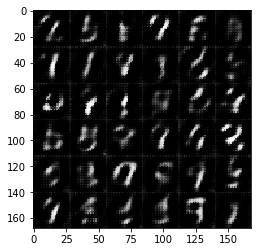

Epoch 1/2... d_loss: 1.2499 g_loss: 1.7698
Epoch 1/2... d_loss: 0.9906 g_loss: 0.8242
Epoch 1/2... d_loss: 1.8113 g_loss: 0.2697
Epoch 1/2... d_loss: 1.1061 g_loss: 1.4229
Epoch 1/2... d_loss: 0.9438 g_loss: 1.1734
Epoch 1/2... d_loss: 1.6173 g_loss: 0.3303
Epoch 1/2... d_loss: 1.6570 g_loss: 0.3307
Epoch 1/2... d_loss: 1.0322 g_loss: 0.9432
Epoch 1/2... d_loss: 1.3884 g_loss: 0.6119
Epoch 1/2... d_loss: 1.1124 g_loss: 1.0344


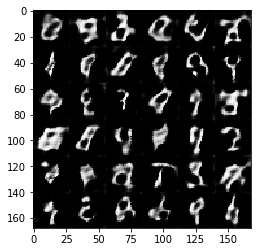

Epoch 1/2... d_loss: 1.1798 g_loss: 1.0036
Epoch 1/2... d_loss: 1.2133 g_loss: 0.6523
Epoch 1/2... d_loss: 1.1890 g_loss: 0.8761
Epoch 1/2... d_loss: 1.2316 g_loss: 0.6745
Epoch 1/2... d_loss: 1.0825 g_loss: 0.7295
Epoch 1/2... d_loss: 1.1634 g_loss: 1.1947
Epoch 1/2... d_loss: 1.0311 g_loss: 1.2811
Epoch 1/2... d_loss: 1.5907 g_loss: 1.8755
Epoch 1/2... d_loss: 1.0977 g_loss: 0.7409
Epoch 1/2... d_loss: 1.1784 g_loss: 0.8680


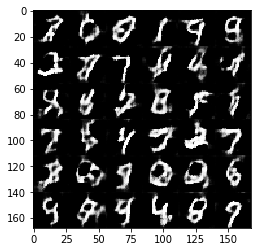

Epoch 1/2... d_loss: 1.8628 g_loss: 0.2292
Epoch 1/2... d_loss: 1.0912 g_loss: 1.1608
Epoch 1/2... d_loss: 1.1153 g_loss: 0.7285
Epoch 1/2... d_loss: 1.3542 g_loss: 0.4972
Epoch 1/2... d_loss: 1.1468 g_loss: 1.1327
Epoch 1/2... d_loss: 1.1394 g_loss: 0.6757
Epoch 1/2... d_loss: 1.2025 g_loss: 1.5812
Epoch 1/2... d_loss: 1.0370 g_loss: 1.2015
Epoch 1/2... d_loss: 1.2380 g_loss: 0.6167
Epoch 1/2... d_loss: 1.0718 g_loss: 1.5658


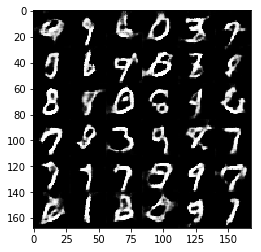

Epoch 1/2... d_loss: 1.2337 g_loss: 1.3907
Epoch 1/2... d_loss: 0.9766 g_loss: 1.5597
Epoch 1/2... d_loss: 1.3543 g_loss: 1.8819
Epoch 1/2... d_loss: 1.0434 g_loss: 0.8715
Epoch 1/2... d_loss: 1.0883 g_loss: 1.1244
Epoch 1/2... d_loss: 0.9831 g_loss: 1.1769
Epoch 2/2... d_loss: 1.1035 g_loss: 0.9461
Epoch 2/2... d_loss: 1.0933 g_loss: 1.0947
Epoch 2/2... d_loss: 1.1765 g_loss: 0.6849
Epoch 2/2... d_loss: 1.2322 g_loss: 0.7120


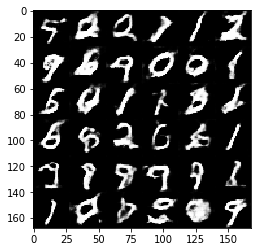

Epoch 2/2... d_loss: 1.0422 g_loss: 0.9679
Epoch 2/2... d_loss: 1.5323 g_loss: 0.3646
Epoch 2/2... d_loss: 1.1325 g_loss: 0.7363
Epoch 2/2... d_loss: 1.4915 g_loss: 0.3642
Epoch 2/2... d_loss: 1.3926 g_loss: 1.5592
Epoch 2/2... d_loss: 1.0739 g_loss: 1.3195
Epoch 2/2... d_loss: 1.0708 g_loss: 0.7148
Epoch 2/2... d_loss: 1.0530 g_loss: 0.9514
Epoch 2/2... d_loss: 1.3100 g_loss: 0.5396
Epoch 2/2... d_loss: 1.2811 g_loss: 0.6577


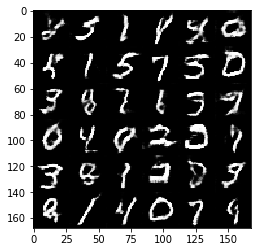

Epoch 2/2... d_loss: 1.1608 g_loss: 0.9142
Epoch 2/2... d_loss: 1.0666 g_loss: 0.9589
Epoch 2/2... d_loss: 1.0378 g_loss: 0.8021
Epoch 2/2... d_loss: 1.3529 g_loss: 0.4502
Epoch 2/2... d_loss: 1.1094 g_loss: 0.8436
Epoch 2/2... d_loss: 1.4726 g_loss: 1.2333
Epoch 2/2... d_loss: 1.1713 g_loss: 1.0815
Epoch 2/2... d_loss: 1.1677 g_loss: 0.6374
Epoch 2/2... d_loss: 1.0065 g_loss: 1.2166
Epoch 2/2... d_loss: 1.1892 g_loss: 0.6363


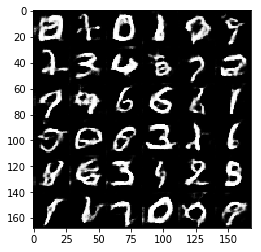

Epoch 2/2... d_loss: 1.0968 g_loss: 0.8086
Epoch 2/2... d_loss: 0.9973 g_loss: 0.7141
Epoch 2/2... d_loss: 1.1365 g_loss: 1.0862
Epoch 2/2... d_loss: 1.0779 g_loss: 1.3461
Epoch 2/2... d_loss: 1.2865 g_loss: 0.5856
Epoch 2/2... d_loss: 1.0806 g_loss: 0.9404
Epoch 2/2... d_loss: 1.0920 g_loss: 0.6813
Epoch 2/2... d_loss: 2.0236 g_loss: 0.2157
Epoch 2/2... d_loss: 0.9908 g_loss: 0.9618
Epoch 2/2... d_loss: 1.0911 g_loss: 0.7212


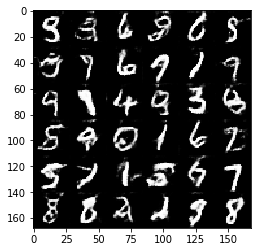

Epoch 2/2... d_loss: 1.2925 g_loss: 0.4728
Epoch 2/2... d_loss: 1.1450 g_loss: 0.8143
Epoch 2/2... d_loss: 1.4021 g_loss: 0.3936
Epoch 2/2... d_loss: 1.1387 g_loss: 0.7349
Epoch 2/2... d_loss: 1.3900 g_loss: 0.4332
Epoch 2/2... d_loss: 1.1553 g_loss: 0.9319
Epoch 2/2... d_loss: 1.2549 g_loss: 0.7809
Epoch 2/2... d_loss: 1.1760 g_loss: 1.0362
Epoch 2/2... d_loss: 1.0857 g_loss: 1.0995
Epoch 2/2... d_loss: 1.3051 g_loss: 1.2278


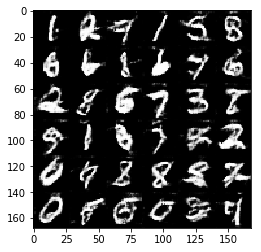

Epoch 2/2... d_loss: 1.4709 g_loss: 0.3827
Epoch 2/2... d_loss: 1.0524 g_loss: 0.8130
Epoch 2/2... d_loss: 1.1809 g_loss: 0.6344


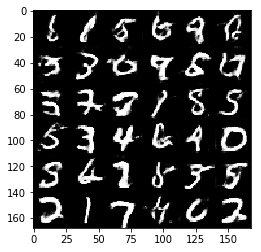

In [11]:
batch_size = 128
z_dim = 100
learning_rate = 0.0011   #--- split between 0.002 and 0.0002
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... d_loss: 0.1762 g_loss: 18.5109
Epoch 1/1... d_loss: 1.1703 g_loss: 1.4870
Epoch 1/1... d_loss: 0.6739 g_loss: 3.8679
Epoch 1/1... d_loss: 1.0719 g_loss: 0.6811
Epoch 1/1... d_loss: 0.3539 g_loss: 3.0339
Epoch 1/1... d_loss: 1.9378 g_loss: 0.2459
Epoch 1/1... d_loss: 0.9551 g_loss: 0.8788
Epoch 1/1... d_loss: 0.2126 g_loss: 2.5118
Epoch 1/1... d_loss: 1.8722 g_loss: 11.0369
Epoch 1/1... d_loss: 6.5256 g_loss: 10.2583


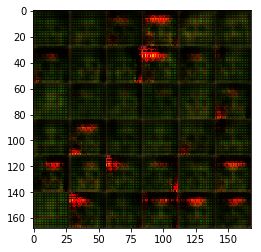

Epoch 1/1... d_loss: 0.8279 g_loss: 0.7921
Epoch 1/1... d_loss: 2.3895 g_loss: 0.1929
Epoch 1/1... d_loss: 1.7522 g_loss: 0.4987
Epoch 1/1... d_loss: 1.3250 g_loss: 0.9404
Epoch 1/1... d_loss: 1.4120 g_loss: 0.6834
Epoch 1/1... d_loss: 1.0875 g_loss: 0.9667
Epoch 1/1... d_loss: 1.7164 g_loss: 0.3556
Epoch 1/1... d_loss: 1.2407 g_loss: 0.9575
Epoch 1/1... d_loss: 1.5955 g_loss: 0.5259
Epoch 1/1... d_loss: 1.6083 g_loss: 0.2975


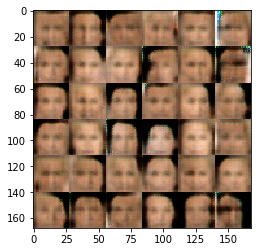

Epoch 1/1... d_loss: 1.4747 g_loss: 0.6031
Epoch 1/1... d_loss: 1.1934 g_loss: 1.0618
Epoch 1/1... d_loss: 1.1343 g_loss: 1.1896
Epoch 1/1... d_loss: 1.1213 g_loss: 0.8832
Epoch 1/1... d_loss: 1.0067 g_loss: 1.4030
Epoch 1/1... d_loss: 1.1046 g_loss: 1.6154
Epoch 1/1... d_loss: 1.2287 g_loss: 0.8867
Epoch 1/1... d_loss: 1.4637 g_loss: 0.7109
Epoch 1/1... d_loss: 1.1069 g_loss: 0.6829
Epoch 1/1... d_loss: 1.1105 g_loss: 1.1819


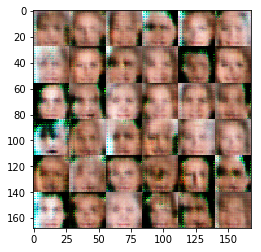

Epoch 1/1... d_loss: 1.2482 g_loss: 0.8237
Epoch 1/1... d_loss: 1.5752 g_loss: 0.5724
Epoch 1/1... d_loss: 2.0642 g_loss: 0.1878
Epoch 1/1... d_loss: 1.1835 g_loss: 0.6826
Epoch 1/1... d_loss: 1.4538 g_loss: 0.7065
Epoch 1/1... d_loss: 1.2259 g_loss: 0.6433
Epoch 1/1... d_loss: 1.1700 g_loss: 1.6195
Epoch 1/1... d_loss: 1.4989 g_loss: 0.4547
Epoch 1/1... d_loss: 0.8458 g_loss: 1.1540
Epoch 1/1... d_loss: 1.0574 g_loss: 1.0965


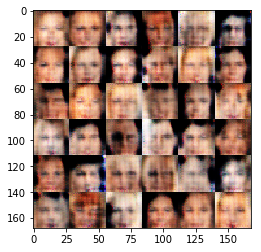

Epoch 1/1... d_loss: 1.5366 g_loss: 0.7867
Epoch 1/1... d_loss: 1.4621 g_loss: 1.0332
Epoch 1/1... d_loss: 1.1807 g_loss: 1.2386
Epoch 1/1... d_loss: 1.5613 g_loss: 1.3315
Epoch 1/1... d_loss: 1.5459 g_loss: 0.7308
Epoch 1/1... d_loss: 1.3553 g_loss: 1.4986
Epoch 1/1... d_loss: 1.2290 g_loss: 0.7028
Epoch 1/1... d_loss: 1.3349 g_loss: 0.8979
Epoch 1/1... d_loss: 1.1060 g_loss: 0.7298
Epoch 1/1... d_loss: 1.2582 g_loss: 0.9075


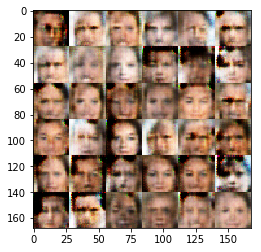

Epoch 1/1... d_loss: 1.3799 g_loss: 1.1512
Epoch 1/1... d_loss: 1.5862 g_loss: 0.2957
Epoch 1/1... d_loss: 1.2428 g_loss: 0.6126
Epoch 1/1... d_loss: 1.0871 g_loss: 0.9762
Epoch 1/1... d_loss: 1.5218 g_loss: 0.4268
Epoch 1/1... d_loss: 1.6357 g_loss: 1.5964
Epoch 1/1... d_loss: 1.2357 g_loss: 0.8378
Epoch 1/1... d_loss: 1.3192 g_loss: 1.1044
Epoch 1/1... d_loss: 1.2364 g_loss: 1.1606
Epoch 1/1... d_loss: 1.3086 g_loss: 0.8108


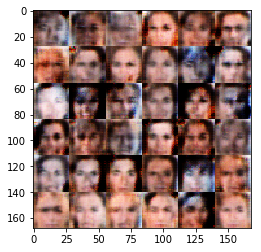

Epoch 1/1... d_loss: 1.3478 g_loss: 0.3877
Epoch 1/1... d_loss: 1.2346 g_loss: 0.7916
Epoch 1/1... d_loss: 1.2919 g_loss: 0.8405
Epoch 1/1... d_loss: 1.1932 g_loss: 1.8797
Epoch 1/1... d_loss: 1.5343 g_loss: 0.3259
Epoch 1/1... d_loss: 1.1555 g_loss: 1.0403
Epoch 1/1... d_loss: 0.9834 g_loss: 1.4693
Epoch 1/1... d_loss: 1.0954 g_loss: 0.7580
Epoch 1/1... d_loss: 1.4824 g_loss: 1.0487
Epoch 1/1... d_loss: 1.2094 g_loss: 0.6815


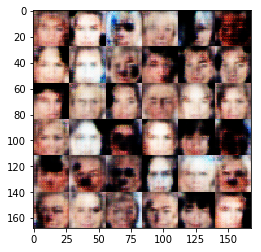

Epoch 1/1... d_loss: 1.6354 g_loss: 0.8896
Epoch 1/1... d_loss: 1.3636 g_loss: 0.7501
Epoch 1/1... d_loss: 1.4990 g_loss: 0.6706
Epoch 1/1... d_loss: 1.2944 g_loss: 0.7657
Epoch 1/1... d_loss: 1.3368 g_loss: 0.7771
Epoch 1/1... d_loss: 1.1716 g_loss: 0.9025
Epoch 1/1... d_loss: 1.3326 g_loss: 0.6725
Epoch 1/1... d_loss: 1.3622 g_loss: 0.9462
Epoch 1/1... d_loss: 1.1809 g_loss: 0.7634
Epoch 1/1... d_loss: 1.3998 g_loss: 0.4334


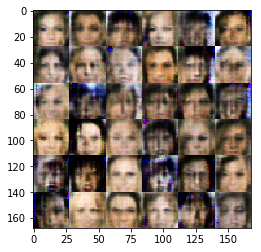

Epoch 1/1... d_loss: 1.2146 g_loss: 0.6702
Epoch 1/1... d_loss: 1.4578 g_loss: 0.5329
Epoch 1/1... d_loss: 1.4352 g_loss: 0.5804
Epoch 1/1... d_loss: 1.2509 g_loss: 0.5729
Epoch 1/1... d_loss: 1.5292 g_loss: 0.4721
Epoch 1/1... d_loss: 1.4444 g_loss: 0.7933
Epoch 1/1... d_loss: 1.2626 g_loss: 0.7898
Epoch 1/1... d_loss: 1.3645 g_loss: 0.5366
Epoch 1/1... d_loss: 1.5782 g_loss: 0.3513
Epoch 1/1... d_loss: 0.7215 g_loss: 1.2783


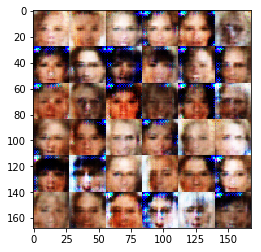

Epoch 1/1... d_loss: 1.6712 g_loss: 0.4880
Epoch 1/1... d_loss: 1.2136 g_loss: 0.7390
Epoch 1/1... d_loss: 1.3171 g_loss: 0.5421
Epoch 1/1... d_loss: 1.5352 g_loss: 0.3903
Epoch 1/1... d_loss: 1.2717 g_loss: 0.6531
Epoch 1/1... d_loss: 1.2853 g_loss: 0.7503
Epoch 1/1... d_loss: 1.2323 g_loss: 0.9582
Epoch 1/1... d_loss: 1.5269 g_loss: 0.4088
Epoch 1/1... d_loss: 1.4332 g_loss: 0.8827
Epoch 1/1... d_loss: 1.3993 g_loss: 0.4293


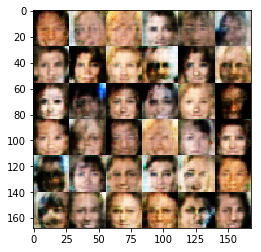

Epoch 1/1... d_loss: 1.4516 g_loss: 0.7987
Epoch 1/1... d_loss: 1.4898 g_loss: 0.9571
Epoch 1/1... d_loss: 1.2169 g_loss: 0.9282
Epoch 1/1... d_loss: 1.4490 g_loss: 0.5356
Epoch 1/1... d_loss: 1.2667 g_loss: 0.8791
Epoch 1/1... d_loss: 1.1595 g_loss: 0.7836
Epoch 1/1... d_loss: 1.3185 g_loss: 0.9668
Epoch 1/1... d_loss: 1.3356 g_loss: 0.6110
Epoch 1/1... d_loss: 1.2781 g_loss: 0.6945
Epoch 1/1... d_loss: 1.4598 g_loss: 0.5262


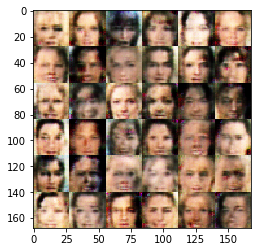

Epoch 1/1... d_loss: 1.2005 g_loss: 0.7511
Epoch 1/1... d_loss: 1.4671 g_loss: 0.5487
Epoch 1/1... d_loss: 1.2894 g_loss: 1.0559
Epoch 1/1... d_loss: 1.3207 g_loss: 0.7442
Epoch 1/1... d_loss: 1.3152 g_loss: 0.7428
Epoch 1/1... d_loss: 1.0604 g_loss: 0.8789
Epoch 1/1... d_loss: 1.4117 g_loss: 0.4812
Epoch 1/1... d_loss: 1.3748 g_loss: 0.7392
Epoch 1/1... d_loss: 1.3766 g_loss: 0.4683
Epoch 1/1... d_loss: 1.3910 g_loss: 1.0924


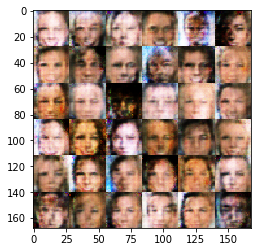

Epoch 1/1... d_loss: 1.4393 g_loss: 0.4639
Epoch 1/1... d_loss: 1.3543 g_loss: 1.0865
Epoch 1/1... d_loss: 1.3477 g_loss: 0.6143
Epoch 1/1... d_loss: 1.3625 g_loss: 0.6171
Epoch 1/1... d_loss: 1.2250 g_loss: 0.8166
Epoch 1/1... d_loss: 1.3881 g_loss: 0.4453
Epoch 1/1... d_loss: 1.6196 g_loss: 0.2911
Epoch 1/1... d_loss: 1.2943 g_loss: 0.8678
Epoch 1/1... d_loss: 1.3610 g_loss: 0.9618
Epoch 1/1... d_loss: 1.2667 g_loss: 0.6707


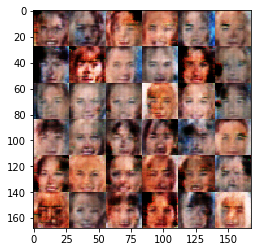

Epoch 1/1... d_loss: 1.4698 g_loss: 0.9924
Epoch 1/1... d_loss: 1.4086 g_loss: 1.0554
Epoch 1/1... d_loss: 1.4909 g_loss: 1.3596
Epoch 1/1... d_loss: 1.3455 g_loss: 0.5997
Epoch 1/1... d_loss: 1.4327 g_loss: 1.2384
Epoch 1/1... d_loss: 2.3597 g_loss: 2.1259
Epoch 1/1... d_loss: 1.4038 g_loss: 0.6784
Epoch 1/1... d_loss: 1.3568 g_loss: 0.6226
Epoch 1/1... d_loss: 1.2648 g_loss: 0.7731
Epoch 1/1... d_loss: 1.3007 g_loss: 0.6797


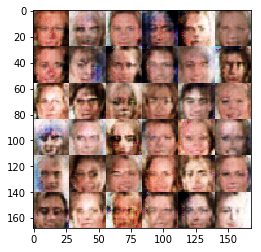

Epoch 1/1... d_loss: 1.3908 g_loss: 0.5799
Epoch 1/1... d_loss: 1.0604 g_loss: 1.0720
Epoch 1/1... d_loss: 1.4230 g_loss: 0.9270
Epoch 1/1... d_loss: 1.5032 g_loss: 0.6915
Epoch 1/1... d_loss: 1.6107 g_loss: 0.3490
Epoch 1/1... d_loss: 1.2453 g_loss: 0.7463
Epoch 1/1... d_loss: 1.5081 g_loss: 0.4725
Epoch 1/1... d_loss: 1.3192 g_loss: 0.8135
Epoch 1/1... d_loss: 1.3457 g_loss: 0.5987
Epoch 1/1... d_loss: 1.3837 g_loss: 0.6440


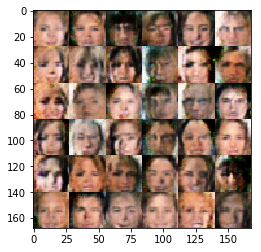

Epoch 1/1... d_loss: 1.3931 g_loss: 0.8414
Epoch 1/1... d_loss: 1.3545 g_loss: 0.7470
Epoch 1/1... d_loss: 1.4959 g_loss: 0.7263
Epoch 1/1... d_loss: 1.3842 g_loss: 1.0976
Epoch 1/1... d_loss: 1.3814 g_loss: 0.7691
Epoch 1/1... d_loss: 1.6178 g_loss: 0.4344
Epoch 1/1... d_loss: 1.3183 g_loss: 0.7626
Epoch 1/1... d_loss: 1.4605 g_loss: 0.8573


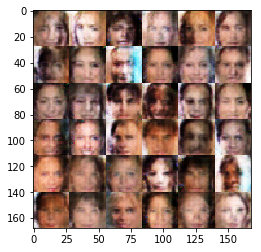

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0011   #--- split between 0.002 and 0.0002
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.